In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

In [2]:
label_names = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
               'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
               'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv']

def import_img(img_name):
    # 이미지 import
    img_path = os.getenv('HOME')+'/aiffel/workspace/Exploration/Ex04/images/'+img_name
    img_orig = cv2.imread(img_path)
    img_orig_blur = cv2.blur(img_orig, (15,15))
    return img_path, img_orig, img_orig_blur

def model_downloard(file_path, downloard = 1):
    # 모델 다운로드
    model_dir = os.getenv('HOME')+file_path
    model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')
    if downloard == 1:
        model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'
        urllib.request.urlretrieve(model_url, model_file)
    return model_file

def build_model(model_file):
    # 세그멘테이션 모델 생성
    model = semantic_segmentation()
    model.load_pascalvoc_model(model_file)
    return model

def img_seg(model, img_path): 
    # 모델 실행
    segvalues, output = model.segmentAsPascalvoc(img_path)
    
    # 세그멘테이션 클래스 출력
    print('your image got')
    for class_id in segvalues['class_ids']:
        print(label_names[class_id])
    return segvalues, output

def seg_mask(segvalues, output):
    # 컬러맵 만들기
    colormap = np.zeros((256, 3), dtype = int)
    ind = np.arange(256, dtype=int)
    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3
            
    # 컬러맵 기반 세그멘테이션 마스크 생성
    seg_mask = []
    for class_id in segvalues['class_ids']:
        seg_color = tuple(np.flip(colormap[class_id]))
        seg_map = np.all(output==seg_color, axis=-1)
        seg_mask.append(seg_map)
    
    return seg_mask

def img_seg_mask(seg_mask, img_orig):   
    # 이미지 세그멘테이션 마스크 생성
    img_seg_mask = []
    for mask in seg_mask:
        img_mask = mask.astype(np.uint8) * 255
        img_seg_mask.append(img_mask)
    
    # 원본 이미지에 세크멘테이션 결과 붙이기
    color_mask = []
    for img_mask in img_seg_mask:
        co_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
        color_mask.append(co_mask)
    
    for c_mask in color_mask[1:]:
        img_orig = cv2.addWeighted(img_orig, 0.6, c_mask, 0.4, 0.0)
    
    img_mask_color = []
    for imask in img_seg_mask:
        imask_color = cv2.cvtColor(imask, cv2.COLOR_GRAY2BGR)
        img_mask_color.append(imask_color)
    
    return img_mask_color, img_seg_mask, img_orig

def img_seg_blur(img_mask_color, img_orig, img_bg_blur, various=0):
    img_concat = None
    
    if various == 0 :
        # 단일 객체를 제외한 모든 부분을 블러 이미지로 채움
        user_value = None
        
        while True:
            user_input = input("insert number (press q is quit): ")
            
            if user_input.lower() == 'q':
                break
            
            try:
                user_value = int(user_input)
                print(f"your number is: {user_value}")
                break
            
            except ValueError:
                print("error")
                
        img_concat = np.where(img_mask_color[user_value]==255, img_orig, img_bg_blur)
    
    elif various == 1:
        # 객체를 모두 제외한 뒷 배경만 블러 이미지로 채움
        img_concat = np.where(img_mask_color[0]==255, img_bg_blur, img_orig)
    
    else :
        # 사용자에게 선명하게할 객체를 입력받음
        numbers = []
        while True:
            user_input = input("insert number (press q is quit): ")
            
            if user_input.lower() == 'q':
                break
            
            try:
                number = int(user_input)
                numbers.append(number)
                print(f"now your number is: {numbers}")
            
            except ValueError:
                print("error")
            
        img_concat = img_orig
        
        for i in number:
            img_concat = np.where(img_mask_color[i]==255, img_concat, img_bg_blur)
            
    return img_concat

- img_seg_mask를 gray scail에서 RGB 채널로 변환하지 못하였음
- 이로인하여 세그멘테이션 컬러 이미지 검출에 에러가 있었음

## 모델 다운로드 및 불러오기

In [3]:
model_path = '/aiffel/workspace/Exploration/Ex04/models'
model_file = model_downloard(model_path, 0)

In [4]:
model = build_model(model_file)

## 단일 객체(사람) 인식

In [5]:
# 이미지 불러오기
me_path, me_orig, me_blur = import_img('me.jpg')

# 세그멘테이션 모델 수행 및 수행 결과 출력(결과 라벨 출력)
me_segvalues, me_output = img_seg(model, me_path)

# 세그멘테이션 기반 마스크 생셩 'warhorse_img_seg_mask'이 최종 출력 마스크
me_seg_mask = seg_mask(me_segvalues, me_output)
me_img_mask_color, me_img_seg_mask, me_show = img_seg_mask(me_seg_mask, me_orig)

# 블러 사진과 접합 진헹
me_concat = img_seg_blur(me_img_mask_color, me_orig, me_blur, 0)

your image got
background
person
insert number (press q is quit): 1
your number is: 1


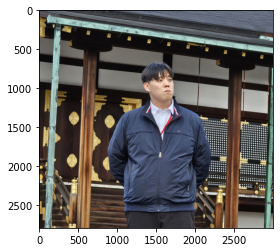

In [6]:
plt.imshow(cv2.cvtColor(me_orig, cv2.COLOR_BGR2RGB))
plt.show()

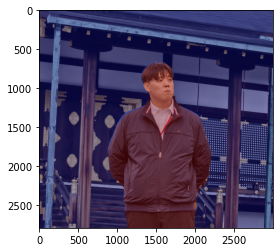

In [7]:
plt.imshow(cv2.cvtColor(me_show, cv2.COLOR_BGR2RGB))
plt.show()

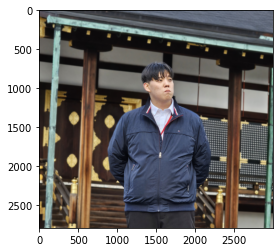

In [8]:
plt.imshow(cv2.cvtColor(me_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 배경 크로마키
- 이미지 출처 (https://en.wikipedia.org/wiki/File:%EA%B2%BD%EB%B3%B5%EA%B6%81_%EA%B4%91%ED%99%94%EB%AC%B8.jpg)

In [9]:
# 이미지 사이즈 확인
me_orig.shape

(2794, 3000, 3)

In [10]:
# 배경 이미지 import
back_img_path = os.getenv('HOME')+'/aiffel/workspace/Exploration/Ex04/images/kwanghwa.jpg'
back_img_orig = cv2.imread(back_img_path)

back_img_orig = cv2.resize(back_img_orig, (3000,2794))

In [11]:
# 배경 이미지와 내 사진 합치기
back_concat = img_seg_blur(me_img_mask_color, me_orig, back_img_orig, 0)

insert number (press q is quit): 1
your number is: 1


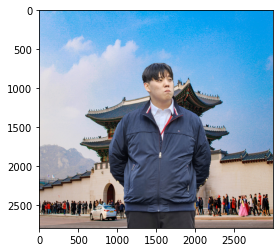

In [12]:
plt.imshow(cv2.cvtColor(back_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 단일 객체(동물) 인식
- 이미지 출처 (https://mypetlife.co.kr/143310/)

In [13]:
# 이미지 불러오기
dog_path, dog_orig, dog_blur = import_img('dog.jpeg')

# 세그멘테이션 모델 수행 및 수행 결과 출력(결과 라벨 출력)
dog_segvalues, dog_output = img_seg(model, dog_path)

# 세그멘테이션 기반 마스크 생셩 'warhorse_img_seg_mask'이 최종 출력 마스크
dog_seg_mask = seg_mask(dog_segvalues, dog_output)
dog_img_mask_color, dog_img_seg_mask, dog_show = img_seg_mask(dog_seg_mask, dog_orig)

# 블러 사진과 접합 진헹
dog_concat = img_seg_blur(dog_img_mask_color, dog_orig, dog_blur, 0)

your image got
background
dog
insert number (press q is quit): 1
your number is: 1


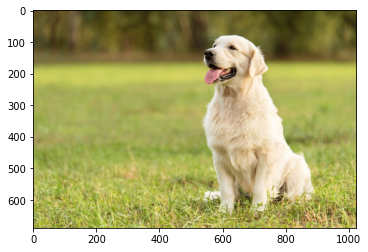

In [14]:
plt.imshow(cv2.cvtColor(dog_orig, cv2.COLOR_BGR2RGB))
plt.show()

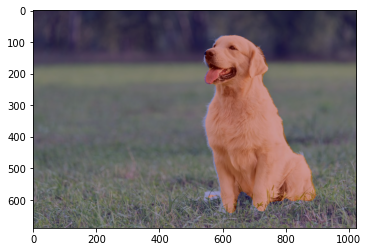

In [15]:
plt.imshow(cv2.cvtColor(dog_show, cv2.COLOR_BGR2RGB))
plt.show()

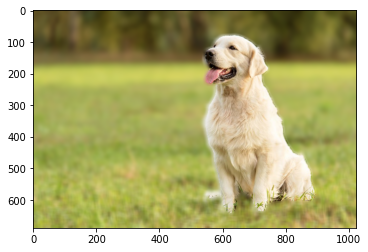

In [16]:
plt.imshow(cv2.cvtColor(dog_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 단일 다중 객체 인식

### 육지 및 바다가 함께 있는 경우
- 이미지 출처 (https://mobile.newsis.com/photo/NISI20231121_0020136715)

In [25]:
# 이미지 불러오기
acb_path, acb_orig, acb_blur = import_img('ammor_car_boat.jpg')

# 세그멘테이션 모델 수행 및 수행 결과 출력(결과 라벨 출력)
acb_segvalues, acb_output = img_seg(model, acb_path)

# 세그멘테이션 기반 마스크 생셩 'warhorse_img_seg_mask'이 최종 출력 마스크
acb_seg_mask = seg_mask(acb_segvalues, acb_output)
acb_img_mask_color, acb_img_seg_mask, acb_show = img_seg_mask(acb_seg_mask, acb_orig)

# 블러 사진과 접합 진헹
acb_concat = img_seg_blur(acb_img_mask_color, acb_orig, acb_blur, 1)

your image got
background
boat
bus
car
train


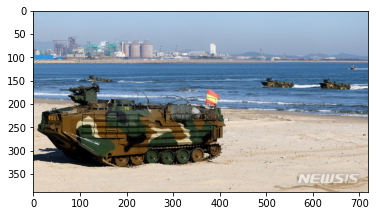

In [26]:
plt.imshow(cv2.cvtColor(acb_orig, cv2.COLOR_BGR2RGB))
plt.show()

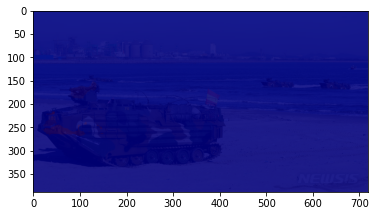

In [27]:
plt.imshow(cv2.cvtColor(acb_show, cv2.COLOR_BGR2RGB))
plt.show()

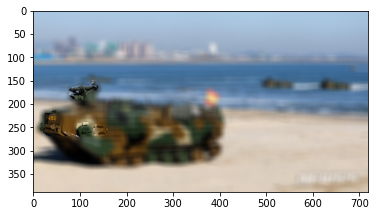

In [28]:
plt.imshow(cv2.cvtColor(acb_concat, cv2.COLOR_BGR2RGB))
plt.show()

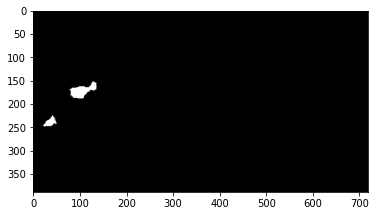

In [29]:
plt.imshow(acb_img_seg_mask[1], cmap='gray')
plt.show()

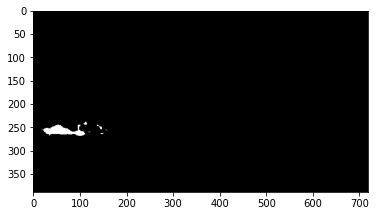

In [30]:
plt.imshow(acb_img_seg_mask[2], cmap='gray')
plt.show()

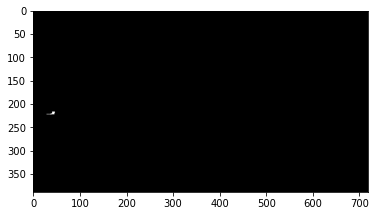

In [44]:
plt.imshow(acb_img_seg_mask[3], cmap='gray')
plt.show()

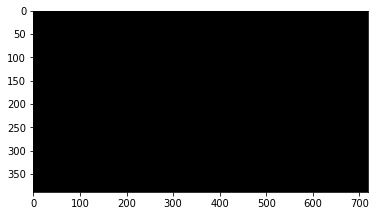

In [45]:
plt.imshow(acb_img_seg_mask[4], cmap='gray')
plt.show()

### 육지에만 있는 경우
- 이미지 출처 (http://www.securityfact.co.kr/news/view.php?no=855)

In [31]:
# 이미지 불러오기
c_path, c_orig, c_blur = import_img('car.png')

# 세그멘테이션 모델 수행 및 수행 결과 출력(결과 라벨 출력)
c_segvalues, c_output = img_seg(model, c_path)

# 세그멘테이션 기반 마스크 생셩 'warhorse_img_seg_mask'이 최종 출력 마스크
c_seg_mask = seg_mask(c_segvalues, c_output)
c_img_mask_color, c_img_seg_mask, c_show = img_seg_mask(c_seg_mask, c_orig)

# 블러 사진과 접합 진헹
c_concat = img_seg_blur(c_img_mask_color, c_orig, c_blur, 1)

your image got
background
boat
car
train


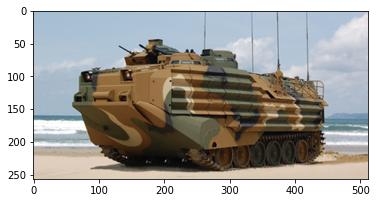

In [32]:
plt.imshow(cv2.cvtColor(c_orig, cv2.COLOR_BGR2RGB))
plt.show()

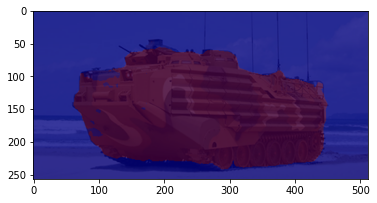

In [33]:
plt.imshow(cv2.cvtColor(c_show, cv2.COLOR_BGR2RGB))
plt.show()

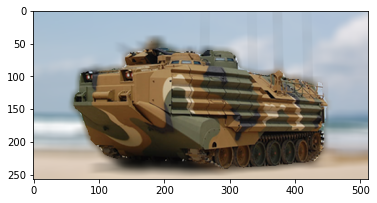

In [34]:
plt.imshow(cv2.cvtColor(c_concat, cv2.COLOR_BGR2RGB))
plt.show()

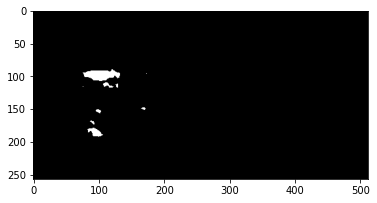

In [36]:
plt.imshow(c_img_seg_mask[1], cmap='gray')
plt.show()

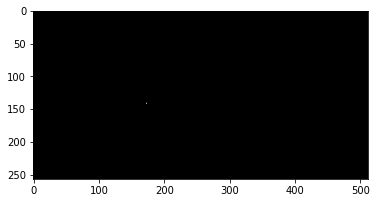

In [37]:
plt.imshow(c_img_seg_mask[2], cmap='gray')
plt.show()

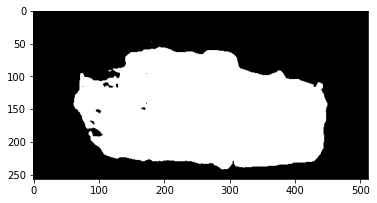

In [38]:
plt.imshow(c_img_seg_mask[3], cmap='gray')
plt.show()

### 바다에만 있는 경우
- 이미지 출처 (https://blog.naver.com/mc341/223497983821)

In [40]:
# 이미지 불러오기
b_path, b_orig, b_blur = import_img('boat.jpg')

# 세그멘테이션 모델 수행 및 수행 결과 출력(결과 라벨 출력)
b_segvalues, b_output = img_seg(model, b_path)

# 세그멘테이션 기반 마스크 생셩 'warhorse_img_seg_mask'이 최종 출력 마스크
b_seg_mask = seg_mask(b_segvalues, b_output)
b_img_mask_color, b_img_seg_mask, b_show = img_seg_mask(b_seg_mask, b_orig)

# 블러 사진과 접합 진헹
b_concat = img_seg_blur(b_img_mask_color, b_orig, b_blur, 1)

your image got
background
boat


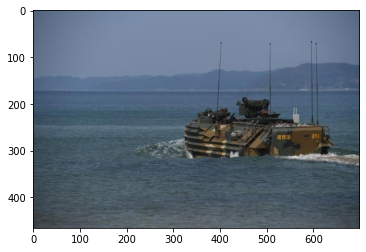

In [41]:
plt.imshow(cv2.cvtColor(b_orig, cv2.COLOR_BGR2RGB))
plt.show()

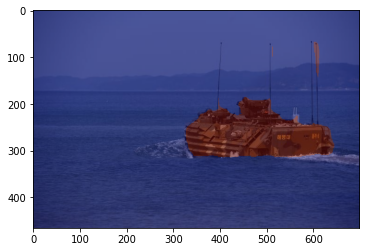

In [42]:
plt.imshow(cv2.cvtColor(b_show, cv2.COLOR_BGR2RGB))
plt.show()

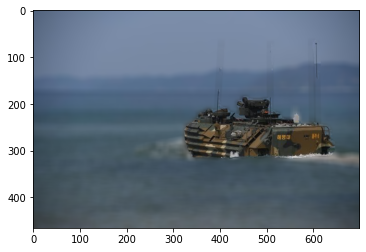

In [43]:
plt.imshow(cv2.cvtColor(b_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 다종(사람, 동물) 다중 객체 인식

### War horse
- 이미지 출처 (https://blog.naver.com/rhrhektzja/100022609185, 구글 검색 이미지)

In [17]:
# 이미지 불러오기
warhorse_path, warhorse_orig, warhorse_blur = import_img('warhorse.png')

# 세그멘테이션 모델 수행 및 수행 결과 출력(결과 라벨 출력)
warhorse_segvalues, warhorse_output = img_seg(model, warhorse_path)

# 세그멘테이션 기반 마스크 생셩 'warhorse_img_seg_mask'이 최종 출력 마스크
warhorse_seg_mask = seg_mask(warhorse_segvalues, warhorse_output)
warhorse_img_mask_color, warhorse_img_seg_mask, warhorse_show = img_seg_mask(warhorse_seg_mask, warhorse_orig)

# 블러 사진과 접합 진헹
warhorse_concat = img_seg_blur(warhorse_img_mask_color, warhorse_orig, warhorse_blur, 1)

your image got
background
aeroplane
horse
person


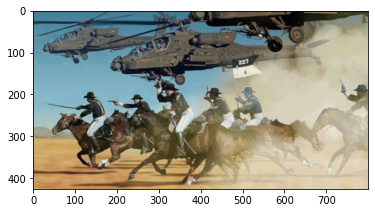

In [18]:
plt.imshow(cv2.cvtColor(warhorse_orig, cv2.COLOR_BGR2RGB))
plt.show()

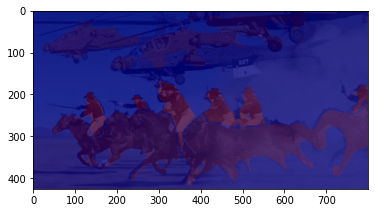

In [19]:
plt.imshow(cv2.cvtColor(warhorse_show, cv2.COLOR_BGR2RGB))
plt.show()

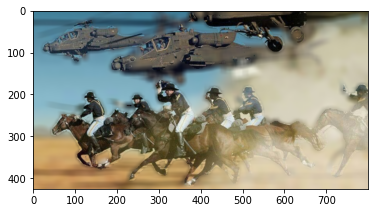

In [20]:
plt.imshow(cv2.cvtColor(warhorse_concat, cv2.COLOR_BGR2RGB))
plt.show()

### Police horse
- 이미지 출처 (https://www.kbmaeil.com/news/articleView.html?idxno=102520)

In [21]:
# 이미지 불러오기
polhorse_path, polhorse_orig, polhorse_blur = import_img('polhorse.png')

# 세그멘테이션 모델 수행 및 수행 결과 출력(결과 라벨 출력)
polhorse_segvalues, polhorse_output = img_seg(model, polhorse_path)

# 세그멘테이션 기반 마스크 생셩 'warhorse_img_seg_mask'이 최종 출력 마스크
polhorse_seg_mask = seg_mask(polhorse_segvalues, polhorse_output)
polhorse_img_mask_color, polhorse_img_seg_mask, polhorse_show = img_seg_mask(polhorse_seg_mask, polhorse_orig)

# 블러 사진과 접합 진헹
polhorse_concat = img_seg_blur(polhorse_img_mask_color, polhorse_orig, polhorse_blur, 1)

your image got
background
car
horse
person


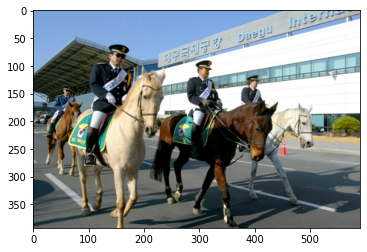

In [22]:
plt.imshow(cv2.cvtColor(polhorse_orig, cv2.COLOR_BGR2RGB))
plt.show()

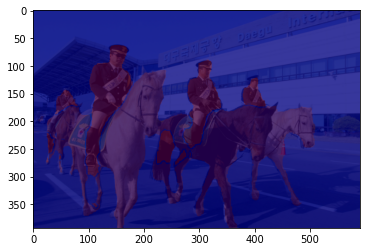

In [23]:
plt.imshow(cv2.cvtColor(polhorse_show, cv2.COLOR_BGR2RGB))
plt.show()

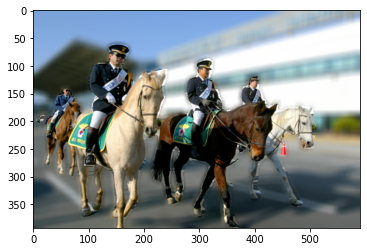

In [24]:
plt.imshow(cv2.cvtColor(polhorse_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 문제점 지적
- segmetation 영역 분리 정확도 부족
    - 주로 객체의 영역을 검출할 때 국소 부위(손가락, 발)에 대한 분할 정확도가 약간 낮음
    <img src="images/p01.png"/>
    <img src="images/p02.png"/>
    - 가끔 전체적인 객체 자체를 검출하지 못하는 경우도 있음
    <img src="images/p03.png"/>
    - 원거리에 있을 경우 검출하는데 더 어려움이 있음
    <img src="images/p04.png"/>
- 잘 못 라벨한 segmetation 영역
    - 특정 객체를 보편적인 의미와 다른 라벨을 붙여서 검출하는 경우
    <img src="images/p05.png"/>
    - 이전에 라벨한 동일한 객체에 대하여, 배경이 바뀐 경우 검출해내지 못하는 경우
    <img src="images/p06.png"/>

## 보완 방법
- 모델의 threshold를 조정하여 라벨이 없는 사진의 경우 확실하게 background로 검출되도록함
- 모델의 더 많은 데이터를 넣고 학습을 진행 (데이터 검출의 범용성 증대)
- 데이터에 stogram equalizatio를 이용하여 경계선 부분이 더 잘 검출되도록함
    https://blog.doctor-cha.com/catch-up-with-segmentation-in-12-days